In [1]:
#!/usr/bin/env python3
# coding: utf-8

# Low Rank Approximation by Image Segmentation
# Written by Prof. R.S. Sreenivas
# For IE531: Algorithms for Data Analytics
# 
import sys
import argparse
import numpy as np 
import time
import math
import matplotlib.pyplot as plt
import cv2
import os
np.set_printoptions(precision=5)



In [2]:
def compute_lower_rank_approx_via_SVD(data_matrix, desired_quality) :
    U,S,V=np.linalg.svd(data_matrix,full_matrices=False)
#    print('original shape=',U.shape,V.shape)
#    print('maximum singlar value shape',U[:,:len(S)].shape,V[:len(S),:].shape)
    TEST=np.matrix(U)*np.diag(S)*np.matrix(V)#TEST IF SVD GENERATE THE DIFFERNCE
#    print('whole USV==INPUT or not',np.allclose(TEST,data_matrix))
  #  print('singular value matrix=',S)
    denominator=np.linalg.norm(data_matrix)
  #  print('input data matrix norm=',denominator)
    current_approximant=0
    if denominator==0:# all black area
        return data_matrix
    for i in range(0,len(S)+1):
        quality = math.sqrt((np.linalg.norm(np.diag(S[:i]))*np.linalg.norm(np.diag(S[:i]))))/denominator
#        print('i=',i,'quality=',quality,'total singular value number=',len(S))
        if quality>=desired_quality:
            current_approximant=np.matrix(U[:,:i])*np.diag(S[:i])*np.matrix(V[:i,:])
            break
        elif i==len(S) and np.allclose(quality,desired_quality)==True:
            current_approximant=np.matrix(U[:,:i])*np.diag(S[:i])*np.matrix(V[:i,:])
#    print('approximated USV==INPUT or not',np.allclose(current_approximant,data_matrix))
    return np.array(current_approximant)



In [3]:
def block_cut(data_matrix,k):#got replaced by np.split_array, which is  more convenient
    first_dimension_size=data_matrix.shape[0]
    second_dimension_size=data_matrix.shape[1]
    first_dimension_cut=[]
    second_dimension_cut=[]
    n1=math.floor(first_dimension_size/k)
    n2=math.floor(second_dimension_size/k)
    d1=first_dimension_size%k
    d2=second_dimension_size%k
    while len(first_dimension_cut)<k:
        if len(first_dimension_cut)<d1:
            first_dimension_cut.append(n1+1)
        else:
            first_dimension_cut.append(n1)
        if len(second_dimension_cut)<d2:
            second_dimension_cut.append(n2+1)
        else:
            second_dimension_cut.append(n2)
    
    return first_dimension_cut,second_dimension_cut

def compute_image_block(data_matrix, k) :
    # Fill code here
    # image_block is a (k x k) matrix, where the (i,j)-th entry is a matrix of appropriate shape
    image_block=[]
    #following idea in https://stackoverflow.com/questions/33789191/how-can-i-split-an-array-of-numbers-evenly/33789711
    first_dimension_cut=np.array_split(data_matrix,k)
    for i in range(0,k):
        second_dimension_cut=np.array_split(first_dimension_cut[i],k,axis=1)
        image_block.append(second_dimension_cut)
    return image_block
#Stored in a list, each list is a cut based on rows, each list element is the column cut on the prev


In [4]:
#A = np.random.random((10,9))
#first_dimension_cut,second_dimension_cut=block_cut(A,4)
#A.shape

In [5]:
#data_matrix=compute_image_block(A,4)[0][1]
#np.linalg.svd(data_matrix,full_matrices=False)
#compute_lower_rank_approx_via_SVD(data_matrix,0.95)

In [6]:
#data_matrix=compute_image_block(A,4)
#data_matrix[0]

In [7]:
# this function takes the k x k image_block and reconstucts a single data_matrix from it
def reconstruct_data_from_image_block(image_block, k) :
    temp=np.hstack(image_block[0])#initialization the first several rows cut by the previous funcitons
    for i in range(1,k):
        to_be_stacked=np.hstack(image_block[i])
        temp=np.vstack((temp,to_be_stacked))
    data_matrix=temp
    return data_matrix

In [8]:
#testing if reconstruct_data_from_image_block works
#A = np.random.random((10,9))
#data_matrix=compute_lower_rank_approx_via_SVD(A, 0.90)
#data_matrix[0]
#reconstruct_data_from_image_block(data_matrix,4),A

In [19]:
# find the lower rank approximation for a given quality on each block of segmented data
# the "verbose" boolean variable is set to True if we want to print the shape of the segmented data
def get_approximation(data_matrix, k, quality, verbose) :
    # Fill code here
    # First -- take the data_matrix and cut it up into (k x k) blocks, where each (i,j)-entry is a
    # matrix of appropriate size
    # Second -- find the approximants for each matrix that is the (i,j)-th entry of the block
    # Third -- reconstruct the approximant to the data-matrix from the block-approximants
    # The "verbose" boolean is for the printing the shapes of the segmented blocks
    image_blocks=compute_image_block(data_matrix,k)
    temp_rows=[]
    for i in range(0,k):
        temp_columns=[]
        row_cutted_block=image_blocks[i]
    #print('row_cutted_block=',row_cutted_block)
        for j in range(0,k):        
            single_block=row_cutted_block[j]
    #    print('single block=',row_cutted_block[j])
            approximated_block=compute_lower_rank_approx_via_SVD(single_block,quality)
    #    print('approximated_block=',approximated_block)
            temp_columns.append(approximated_block)
            if verbose==True:
                print('shape of ',(i+1,j+1),'block:',single_block.shape)
    #print('temp_columns',temp_columns)
        temp_rows.append(temp_columns)
    print('temp_rows=',temp_rows[0])
    return reconstruct_data_from_image_block(temp_rows, k)




shape of  (1, 1) block: (3, 3)
shape of  (1, 2) block: (3, 3)
shape of  (1, 3) block: (3, 2)
shape of  (1, 4) block: (3, 2)
shape of  (2, 1) block: (3, 3)
shape of  (2, 2) block: (3, 3)
shape of  (2, 3) block: (3, 2)
shape of  (2, 4) block: (3, 2)
shape of  (3, 1) block: (2, 3)
shape of  (3, 2) block: (2, 3)
shape of  (3, 3) block: (2, 2)
shape of  (3, 4) block: (2, 2)
shape of  (4, 1) block: (2, 3)
shape of  (4, 2) block: (2, 3)
shape of  (4, 3) block: (2, 2)
shape of  (4, 4) block: (2, 2)
temp_rows= [array([[0.78965, 0.14171, 0.2896 ],
       [0.49966, 0.37077, 0.84944],
       [0.65077, 0.13915, 0.663  ]]), array([[0.23378, 0.84822, 0.27866],
       [0.1734 , 0.60737, 0.47391],
       [0.84861, 0.16167, 0.27989]]), array([[0.19615, 0.34956],
       [0.72937, 0.34634],
       [0.5243 , 0.44637]]), array([[0.35461, 0.07858],
       [0.53112, 0.37085],
       [0.09983, 0.1467 ]])]
temp_rows= [array([[0.78875, 0.1    , 0.30558],
       [0.4986 , 0.32179, 0.8682 ],
       [0.65266, 0.226

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


temp_rows= [array(0), array([[  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
          0.     ],
       [  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
          0.     ],
       [  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
          0.     ],
       ...,
       [  0.     ,   0.     ,   0.     , ..., 136.36203, 110.49506,
         76.96108],
       [  0.     ,   0.     ,   0.     , ..., 110.98296, 130.4228 ,
        124.64776],
       [  0.     ,   0.     ,   0.     , ...,  87.43399,  99.74624,
        114.1853 ]]), array([[ -1.32711,  -0.15946,  -0.31318, ...,   0.     ,   0.     ,
          0.     ],
       [ -2.20484,  -0.56433,  -0.37255, ...,   0.     ,   0.     ,
          0.     ],
       [  3.08421,  -2.17733,  -3.18316, ...,   0.     ,   0.     ,
          0.     ],
       ...,
       [ 67.5667 ,  66.29953, 104.50046, ...,   0.     ,   0.     ,
          0.     ],
       [117.09718,  63.97679,  52.64059, ...,   0.     ,   0.     ,
    

ValueError: all the input arrays must have same number of dimensions

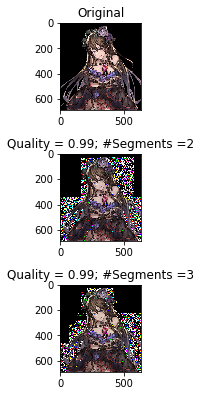

In [22]:

# verifying the block reconstruction procedure
A = np.random.random((10,10))
B = get_approximation(A, 4, 1, True)
C = get_approximation(A, 4, 0.99, False)
print(np.allclose(A,B))
print(np.allclose(A,C))
# matrix computations will yield a 64-bit floating point number; for images we need these
# to converted into the range 0 to 255 of 8-bit ints 

def convert_float64_to_uint8(A) :
    A = A/A.max()
    A = 255 * A
    return A.astype(np.uint8)

# this function "combines" the three color matrices (in the required order) to form a 3D
# array that can be rendered/viewed 
def reconstruct_image_from_RGB_64bit_matrices(red, blue, green) :
    reconstructed_image = cv2.merge([convert_float64_to_uint8(blue), 
                                     convert_float64_to_uint8(green), 
                                     convert_float64_to_uint8(red)])
    return reconstructed_image

# first command-line variable is the image path
IMAGE = 'BBA.png'
#IMAGE = 'altgeld_hall.jpg'
image = cv2.imread(IMAGE)

# we need to change the colorspace to make the colors in the image look right
# when we do an imshow 
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
# if you want to work with a grayscale image comment the previous line & 
# uncomment the line below
#gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# split the image into blue-green-red components -- keep in mind that each of 
# these entries are 8-bit ints (i.e. have a value between 0 and 255)
blue_image = image[:,:,0]
green_image = image[:,:,1]
red_image = image[:,:,2]

# second command-line variable is the quality/fidelity of approximation
#quality = float(sys.argv[2])
quality = 0.99

# let us try k = 2, 3, 4, 5 and see how the image segmentation works out

# from https://matplotlib.org/gallery/subplots_axes_and_figures/figure_title.html and 
# from https://stackoverflow.com/questions/41530975/set-size-of-subplot-in-matplotlib
fig = plt.figure(figsize=(6, 9))
image_index = 1
axs = fig.add_subplot(5,1, image_index)
fig.tight_layout()
plt.imshow(image)
axs.set_title('Original')
image_index = image_index + 1

for k in range(2,6) :
    b = get_approximation(blue_image, k, 1 - ((1-quality)/k), False)
    g = get_approximation(green_image, k, 1 - ((1-quality)/k), False)
    r = get_approximation(red_image, k, 1 - ((1-quality)/k), False)
    axs = fig.add_subplot(5,1, image_index)
    fig.tight_layout()
    reconstructed_image = reconstruct_image_from_RGB_64bit_matrices(r, b, g)
    plt.imshow(reconstructed_image)
    axs.set_title('Quality = ' + str(round(quality,5)) + '; #Segments =' + str(k))
    image_index = image_index + 1
    
plt.savefig("fig1.pdf", bbox_inches='tight')
plt.show()

